In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tool._fixedInt import *

In [16]:
class PRBS9(object):
    def __init__(self, seed):
        self.reg = []
        self.seed = int(seed, base=16)
        [self.reg.append(1) if self.seed & (1 << i) else self.reg.append(0) for i in range(9)]
    
    def gen_bit(self):
        bit_out = self.reg[8]
        bit_in = self.reg[8] ^ self.reg[4]
        self.reg = [bit_in] + self.reg[:len(self.reg)-1]
        return bit_out


class Encoder(object):
    def encode(self, bit):
        n_bit = 1 if bit == 0 else -1
        return n_bit


class FIRFilter(object):
    def __init__(self, Nphases, coeffs, intW, fracW):
        self.intW = intW
        self.fracW = fracW
        self.Ncoeffs          = len(coeffs)
        self.select           = 0
        self.Nphases          = Nphases
        self.num_phase_coeffs = int(len(coeffs)/Nphases)
        self.samples_reg      = [0]*self.num_phase_coeffs
        self.p                = [[0 for x in range(self.num_phase_coeffs)] for y in range(Nphases)]
        x                     = 0
        for j in range(self.num_phase_coeffs):
            for i in range(Nphases):
                self.p[i][j] = coeffs[x]
                x += 1

    def add_sample(self, sample):
        self.samples_reg = [sample] + self.samples_reg[:len(self.samples_reg)-1]
        
    def process_sample(self):
        y = DeFixedInt(roundMode='trunc', signedMode = 'S', intWidth=self.intW+self.num_phase_coeffs, fractWidth=self.fracW, saturateMode='saturate')
        y.value = 0.0
        for i in range(self.num_phase_coeffs):
            if self.samples_reg[i] == 1:
                y.assign(y + self.p[self.select][i])
            else:
                aux = DeFixedInt(roundMode='trunc', signedMode = 'S', intWidth=self.intW, fractWidth=self.fracW, saturateMode='saturate')
                aux.value = -self.p[self.select][i].value
                y.assign(y + aux)
        #    y += self.p[self.select][i].fValue if self.samples_reg[i] == 1 else -self.p[self.select][i].fValue
        self.select += 1
        self.select = 0 if self.select > 3 else self.select
        out = DeFixedInt(roundMode='trunc', signedMode = 'S', intWidth=self.intW, fractWidth=self.fracW, saturateMode='saturate')
        out.value = y.value
        return out
    
    def getNphases(self):
        return self.Nphases

    def getNCoeffs(self):
        return self.Ncoeffs

    def getNumPhaseCoeffs(self):
        return self.num_phase_coeffs

    def resetFilter(self):
        self.samples_reg = [0]*self.num_phase_coeffs
        self.select      = 0
    
    def printCoeffsfValues(self):
        print('Coeffs fValues:')
        for i in range(self.Nphases):
            p = []
            for c in self.p[i]:
                p.append(c.fValue)
            print('phase[' + str(i) + ']: ' + str(p))
    
    def printCoeffsIntValues(self):
        print('Coeffs intvalues:')
        for i in range(self.Nphases):
            p = []
            for c in self.p[i]:
                p.append(c.intvalue)
            print('phase[' + str(i) + ']: ' + str(p))


In [17]:
def rcosine(beta, Tbaud, oversampling, Nbauds, Norm):
    """ Raised cosine filter impulse response """
    t_vect = np.arange(-0.5*Nbauds*Tbaud, 0.5*Nbauds*Tbaud, float(Tbaud)/oversampling)
    y_vect = []
    for t in t_vect:
        y_vect.append(np.sinc(t/Tbaud)*(np.cos(np.pi*beta*t/Tbaud)/(1-(4.0*beta*beta*t*t/(Tbaud*Tbaud)))))
    y_vect = np.array(y_vect)
    if(Norm):
        return (t_vect, y_vect/np.sqrt(np.sum(y_vect**2)))
        #return (t_vect, y_vect/y_vect.sum())
    else:
        return (t_vect,y_vect)


def resp_freq(filt, Ts, Nfreqs):
    """FIR Filter frequency response"""
    H = []
    A = []
    filt_len = len(filt)

    freqs = np.matrix(np.linspace(0,1.0/(2.0*Ts),Nfreqs))
    Lseq = 20.0/(freqs[0,1]*Ts)

    t = np.matrix(np.arange(0,Lseq))*Ts

    Omega = 2.0j*np.pi*(t.transpose()*freqs)

    fin = np.exp(Omega)

    for i in range(0,np.size(fin,1)):
        fout = np.convolve(np.squeeze(np.array(fin[:,i].transpose())),filt)
        mfout = abs(fout[filt_len:len(fout)-filt_len])
        afout = np.angle(fout[filt_len:len(fout)-filt_len])
        H.append(mfout.sum()/len(mfout))
        A.append(afout.sum()/len(afout))

    return [H,A,list(np.squeeze(np.array(freqs)))]


def eyediagram(data, n, offset, period):
    span     = 2*n
    segments = int(len(data)/span)
    xmax     = (n-1)*period
    xmin     = -(n-1)*period
    x        = list(np.arange(-n,n,)*period)
    xoff     = offset

    plt.figure()
    for i in range(0,segments-1):
        plt.plot(x, data[(i*span+xoff):((i+1)*span+xoff)],'b')       
    plt.grid(True)
    plt.xlim(xmin, xmax)
    plt.show()

In [18]:
## General Parameters
T      = 1.0/21.0e9    # Baud period
Nsymb  = 2**9          # Number of symbols

os     = 4             # Oversampling

Nfreqs = 256           # Number of frequecies for fft

## Raised cosine filter parameters
beta   = 0.5           # Roll-Off
Nbauds = 6             

Ts     = T/os          # Sampling frequency

## Fixed point
intW  = 12
fracW = 10

In [19]:
(t, rc0) = rcosine(beta, T, os, Nbauds, Norm=False)
rc_0 = arrayFixedInt(intW, fracW, rc0, signedMode='S', roundMode='trunc', saturateMode='saturate')
for ptr in range(len(rc0)):
    rc0[ptr] = rc_0[ptr].fValue

prbs9I   = PRBS9    ('0x1AA')
prbs9Q   = PRBS9    ('0x1FE')
encoderI = Encoder  (       )
encoderQ = Encoder  (       )
rcTxI    = FIRFilter(os, rc_0, intW, fracW)
rcTxQ    = FIRFilter(os, rc_0, intW, fracW)

rcTxI.printCoeffsfValues()
rcTxI.printCoeffsIntValues()

bitsI      = []
bitsQ      = []
symbolsI   = []
symbolsQ   = []
symb_out0I = []
symb_out0Q = []

Coeffs fValues:
phase[0]: [0.0, -0.0009765625, 0.0, 1.0, -0.0009765625, 0.0]
phase[1]: [0.00390625, -0.0576171875, 0.26171875, 0.88671875, -0.123046875, 0.0224609375]
phase[2]: [0.0166015625, -0.1201171875, 0.599609375, 0.599609375, -0.1201171875, 0.0166015625]
phase[3]: [0.0224609375, -0.123046875, 0.88671875, 0.26171875, -0.0576171875, 0.00390625]
Coeffs intvalues:
phase[0]: [0, 4095, 0, 1024, 4095, 0]
phase[1]: [4, 4037, 268, 908, 3970, 23]
phase[2]: [17, 3973, 614, 614, 3973, 17]
phase[3]: [23, 3970, 908, 268, 4037, 4]


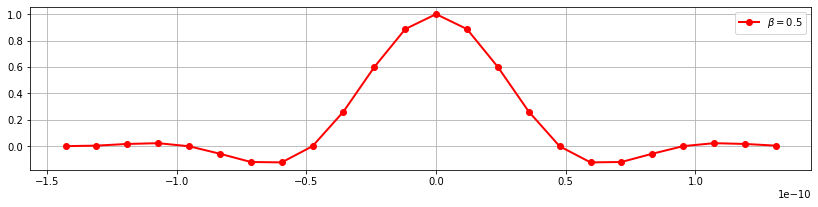

In [20]:
plt.figure(figsize=[14,3])
plt.plot(t,rc0,'ro-',linewidth=2.0,label=r'$\beta=$' + str(beta))
plt.legend()
plt.grid(True)
#plt.xlim(0,len(rc0)-1)

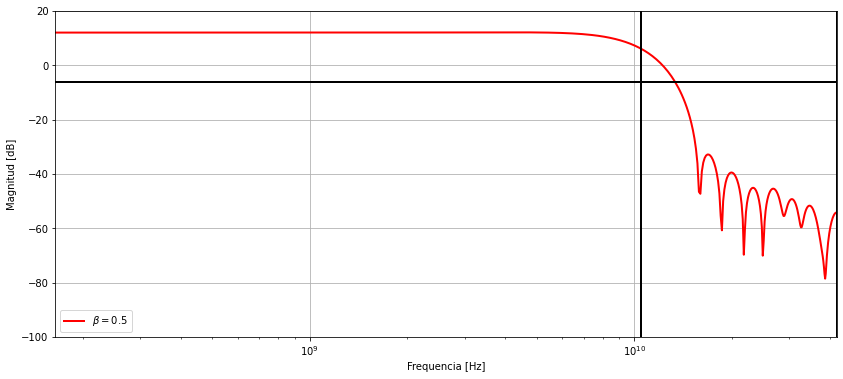

In [21]:
[H0,A0,F0] = resp_freq(rc0, Ts, Nfreqs)

plt.figure(figsize=[14,6])
plt.semilogx(F0, 20*np.log10(H0),'r', linewidth=2.0, label=r'$\beta=$' + str(beta))

plt.axvline(x=(1./Ts)/2.,color='k',linewidth=2.0)
plt.axvline(x=(1./T)/2.,color='k',linewidth=2.0)
plt.axhline(y=20*np.log10(0.5),color='k',linewidth=2.0)
plt.legend(loc=3)
plt.grid(True)
plt.xlim(F0[1],F0[len(F0)-1])
plt.ylim(-100,20)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.show()

In [22]:
rcTxI.resetFilter()
Nphases = rcTxI.getNphases()
Pcoeffs = rcTxI.getNumPhaseCoeffs()

for i in range(Nsymb + Pcoeffs):
    if i < Nsymb:
        bitI = prbs9I.gen_bit()
        bitQ = prbs9Q.gen_bit()
        bitsI.append(bitI)
        bitsQ.append(bitQ)
    
        symbolI = encoderI.encode(bitI)
        symbolQ = encoderQ.encode(bitQ)
        symbolsI.append(symbolI)
        symbolsQ.append(symbolQ)

    rcTxI.add_sample(symbolI) if i < Nsymb else rcTxI.add_sample(0)
    rcTxQ.add_sample(symbolQ) if i < Nsymb else rcTxQ.add_sample(0)

    for j in range(Nphases):
        symb_out0I.append(rcTxI.process_sample())
        symb_out0Q.append(rcTxQ.process_sample())

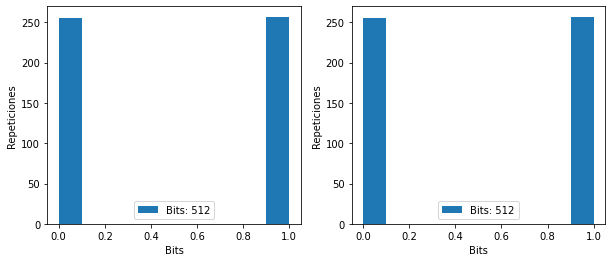

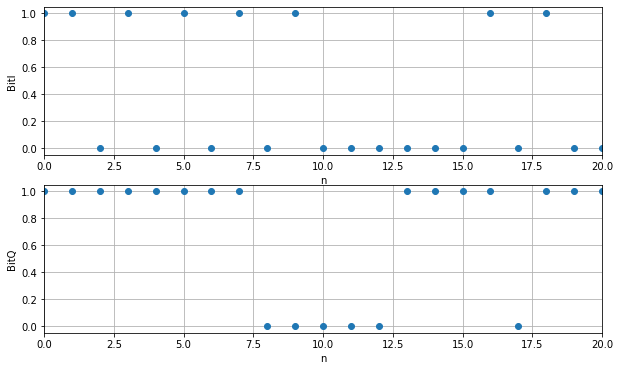

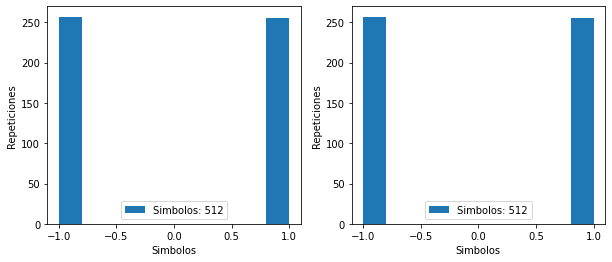

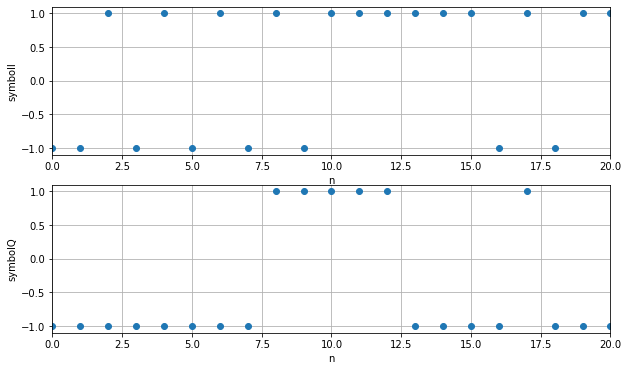

In [23]:
#print(symbolsI)
#print(symbolsQ)

label = 'Bits: %d' % Nsymb
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.hist(bitsI,label=label)
plt.legend(loc='lower center')
plt.xlabel('Bits')
plt.ylabel('Repeticiones')
plt.subplot(1,2,2)
plt.hist(bitsQ,label=label)
plt.legend(loc='lower center')
plt.xlabel('Bits')
plt.ylabel('Repeticiones')
plt.show()

plt.figure(figsize=[10,6])
plt.subplot(2,1,1)
plt.plot(bitsI,'o')
plt.xlim(0,20)
plt.xlabel('n')
plt.ylabel('BitI')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(bitsQ,'o')
plt.xlim(0,20)
plt.xlabel('n')
plt.ylabel('BitQ')
plt.grid(True)
plt.show()

label = 'Simbolos: %d' % Nsymb
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.hist(symbolsI,label=label)
plt.legend(loc='lower center')
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')
plt.subplot(1,2,2)
plt.hist(symbolsQ,label=label)
plt.legend(loc='lower center')
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')
plt.show()

plt.figure(figsize=[10,6])
plt.subplot(2,1,1)
plt.plot(symbolsI,'o')
plt.xlim(0,20)
plt.xlabel('n')
plt.ylabel('symbolI')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(symbolsQ,'o')
plt.xlim(0,20)
plt.xlabel('n')
plt.ylabel('symbolQ')
plt.grid(True)
plt.show()


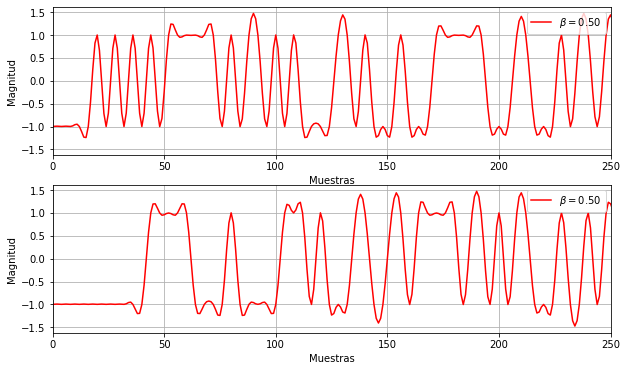

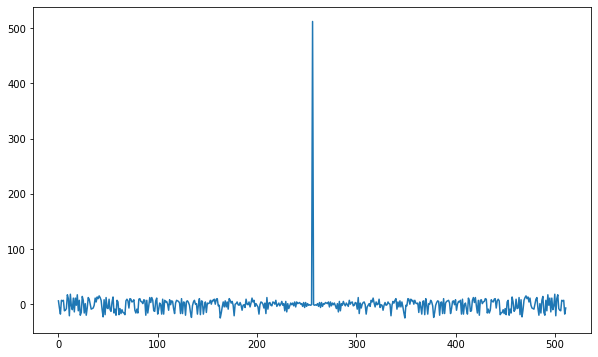

In [24]:
out0I = []
[out0I.append(i.fValue) for i in symb_out0I]
out0Q = []
[out0Q.append(i.fValue) for i in symb_out0Q]  

plt.figure(figsize=[10,6])
plt.subplot(2,1,1)
plt.plot(out0I,'r-',linewidth=1.5,label=r'$\beta=%2.2f$'%beta)
#plt.xlim(1000,1250)
plt.xlim(0,250)
#plt.xlim(len(symb_out0I)-250,len(symb_out0I))
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.subplot(2,1,2)
plt.plot(out0Q,'r-',linewidth=1.5,label=r'$\beta=%2.2f$'%beta)
#plt.xlim(1000,1250)
plt.xlim(0,250)
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.show()

# debug
Ncoeffs = rcTxI.getNCoeffs()
aux = out0I[int(Ncoeffs/2):int(len(out0I)-(Ncoeffs/2)):int(os)]
symb_in0I = []
for i in aux:
    symb_in0I.append(2*(i>0.0)-1)

corr = np.correlate(np.real(symbolsI),np.real(symb_in0I),'same')
plt.figure(figsize=[10,6])
plt.plot(corr)
plt.show()
#debug

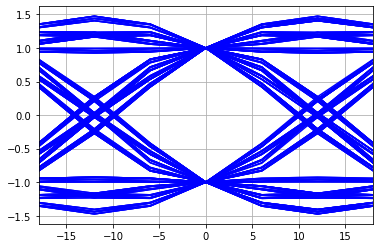

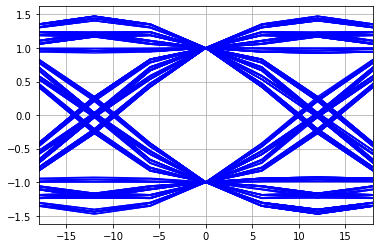

In [25]:
eyediagram(out0I[100:len(out0I)-100],os,0,Nbauds)
eyediagram(out0Q[100:len(out0Q)-100],os,0,Nbauds)
plt.show()

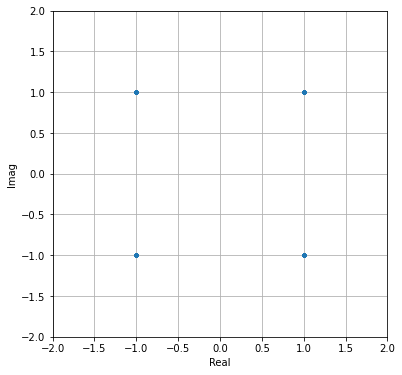

In [26]:
offset = 0
plt.figure(figsize=[6,6])
plt.plot(out0I[100+offset:len(out0I)-(100-offset):int(os)],
         out0Q[100+offset:len(out0Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')

plt.show()

In [27]:
c=DeFixedInt(12,10,'S','trunc','saturate')
print(rc0)
a = rc_0[4] + rc_0[4]

rcTxI.printCoeffsfValues()
rcTxI.printCoeffsIntValues()

print(bitsI)
print(bitsQ)

#for i in symb_out0I:
#    print(i.intvalue)

[ 0.00000000e+00  3.90625000e-03  1.66015625e-02  2.24609375e-02
 -9.76562500e-04 -5.76171875e-02 -1.20117188e-01 -1.23046875e-01
  0.00000000e+00  2.61718750e-01  5.99609375e-01  8.86718750e-01
  1.00000000e+00  8.86718750e-01  5.99609375e-01  2.61718750e-01
 -9.76562500e-04 -1.23046875e-01 -1.20117188e-01 -5.76171875e-02
  0.00000000e+00  2.24609375e-02  1.66015625e-02  3.90625000e-03]
Coeffs fValues:
phase[0]: [0.0, -0.0009765625, 0.0, 1.0, -0.0009765625, 0.0]
phase[1]: [0.00390625, -0.0576171875, 0.26171875, 0.88671875, -0.123046875, 0.0224609375]
phase[2]: [0.0166015625, -0.1201171875, 0.599609375, 0.599609375, -0.1201171875, 0.0166015625]
phase[3]: [0.0224609375, -0.123046875, 0.88671875, 0.26171875, -0.0576171875, 0.00390625]
Coeffs intvalues:
phase[0]: [0, 4095, 0, 1024, 4095, 0]
phase[1]: [4, 4037, 268, 908, 3970, 23]
phase[2]: [17, 3973, 614, 614, 3973, 17]
phase[3]: [23, 3970, 908, 268, 4037, 4]
[1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1